**Set Up Libraries**

In [ ]:
# --- PART 0: INSTALL & IMPORT LIBRARIES ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms as T
from PIL import Image
import os

# Check if running in Colab to import files module
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    import tkinter as tk
    from tkinter import filedialog

def upload_image():
    """
    Universal upload function.
    Uses Google Colab upload if available, otherwise opens local file dialog.
    """
    filename = None
    if IN_COLAB:
        print("\n--- UPLOAD REQUEST ---")
        print("Please click 'Choose Files' to upload an image for this task.")
        uploaded = files.upload()
        if uploaded:
            filename = next(iter(uploaded))
    else:
        print("\n--- UPLOAD REQUEST ---")
        print("Opening file dialog...")
        root = tk.Tk()
        root.withdraw() # Hide main window
        filename = filedialog.askopenfilename(title="Select Image File")

    return filename

print("Libraries loaded successfully!")

Libraries loaded successfully!


**PART 1: Thresholding Segmentation**

STEP 1: Upload an image for Thresholding (e.g., text, simple object)

--- UPLOAD REQUEST ---
Please click 'Choose Files' to upload an image for this task.


Saving 491802098_1321708062666594_8287332425000190740_n.jpg to 491802098_1321708062666594_8287332425000190740_n.jpg


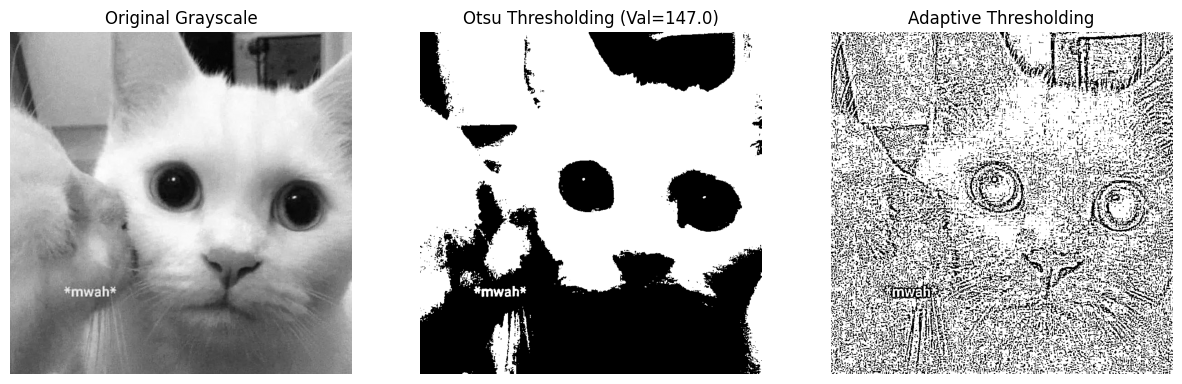

In [ ]:
# --- PART 1: THRESHOLDING SEGMENTATION ---

print("STEP 1: Upload an image for Thresholding (e.g., text, simple object)")
image_path = upload_image()

if image_path:
    # Load image in Grayscale
    img = cv2.imread(image_path, 0)

    # 1. Global Thresholding (Otsu's Method)
    # Calculates the best threshold value automatically
    ret, otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 2. Adaptive Thresholding
    # Calculates threshold for small regions (good for shadows)
    adaptive = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)

    # Display
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Grayscale')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(otsu, cmap='gray')
    plt.title(f'Otsu Thresholding (Val={ret})')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(adaptive, cmap='gray')
    plt.title('Adaptive Thresholding')
    plt.axis('off')

    plt.show()
else:
    print("No image uploaded.")

**PART 2: Region-Based Segmentation (Watershed)**

STEP 2: Upload an image for Region-Based Segmentation (e.g., touching coins)

--- UPLOAD REQUEST ---
Please click 'Choose Files' to upload an image for this task.


Saving 469960801_1108091454450152_3512472422446499624_n.jpg to 469960801_1108091454450152_3512472422446499624_n.jpg


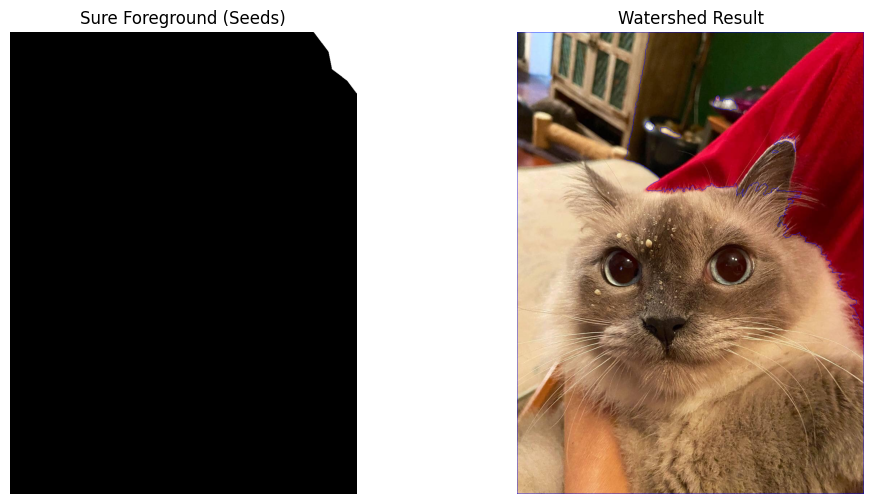

In [ ]:
# --- PART 2: REGION-BASED SEGMENTATION (WATERSHED) ---

print("STEP 2: Upload an image for Region-Based Segmentation (e.g., touching coins)")
image_path = upload_image()

if image_path:
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 1. Binarize (Otsu)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 2. Noise removal
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # 3. Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # 4. Sure foreground area (Distance Transform)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # 5. Unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # 6. Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1 # Add 1 so background is not 0
    markers[unknown == 255] = 0

    # 7. Apply Watershed
    markers = cv2.watershed(img, markers)

    # Mark boundaries in Red for visualization
    img_result = img.copy()
    img_result[markers == -1] = [255,0,0]

    # Display
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(sure_fg, cmap='gray')
    plt.title('Sure Foreground (Seeds)')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
    plt.title('Watershed Result')
    plt.axis('off')
    plt.show()
else:
    print("No image uploaded.")

**PART 3: Edge-Based Segmentation**

STEP 3: Upload an image for Edge Detection

--- UPLOAD REQUEST ---
Please click 'Choose Files' to upload an image for this task.


Saving 493721123_954931193515437_2413896607772580765_n.jpg to 493721123_954931193515437_2413896607772580765_n.jpg


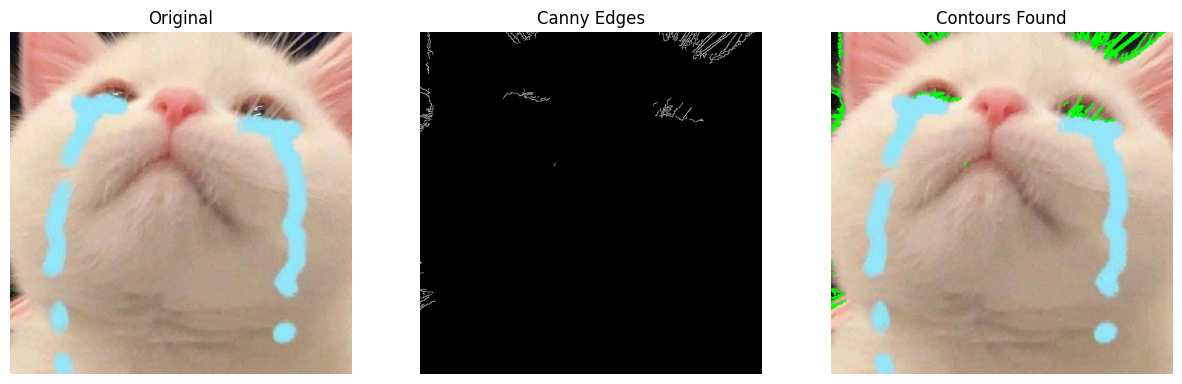

In [ ]:
# --- PART 3: EDGE-BASED SEGMENTATION (CANNY + CONTOURS) ---

print("STEP 3: Upload an image for Edge Detection")
image_path = upload_image()

if image_path:
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 1. Canny Edge Detection
    # Thresholds 100 and 200 are standard starting points
    edges = cv2.Canny(gray, 100, 200)

    # 2. Find Contours (using the edges)
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 3. Draw Contours
    contour_img = img.copy()
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

    # Display
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(edges, cmap='gray')
    plt.title('Canny Edges')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
    plt.title('Contours Found')
    plt.axis('off')

    plt.show()
else:
    print("No image uploaded.")

**PART 4: Semantic Segmentation (Deep Learning)**

Initializing Model... (Downloading weights, please wait...)
Model loaded on cpu!

--- UPLOAD A NEW IMAGE TO TEST ---


Saving 195888d2-3ab4-414e-a3ba-49e771347c17.jpg to 195888d2-3ab4-414e-a3ba-49e771347c17 (1).jpg
Processing 195888d2-3ab4-414e-a3ba-49e771347c17 (1).jpg...


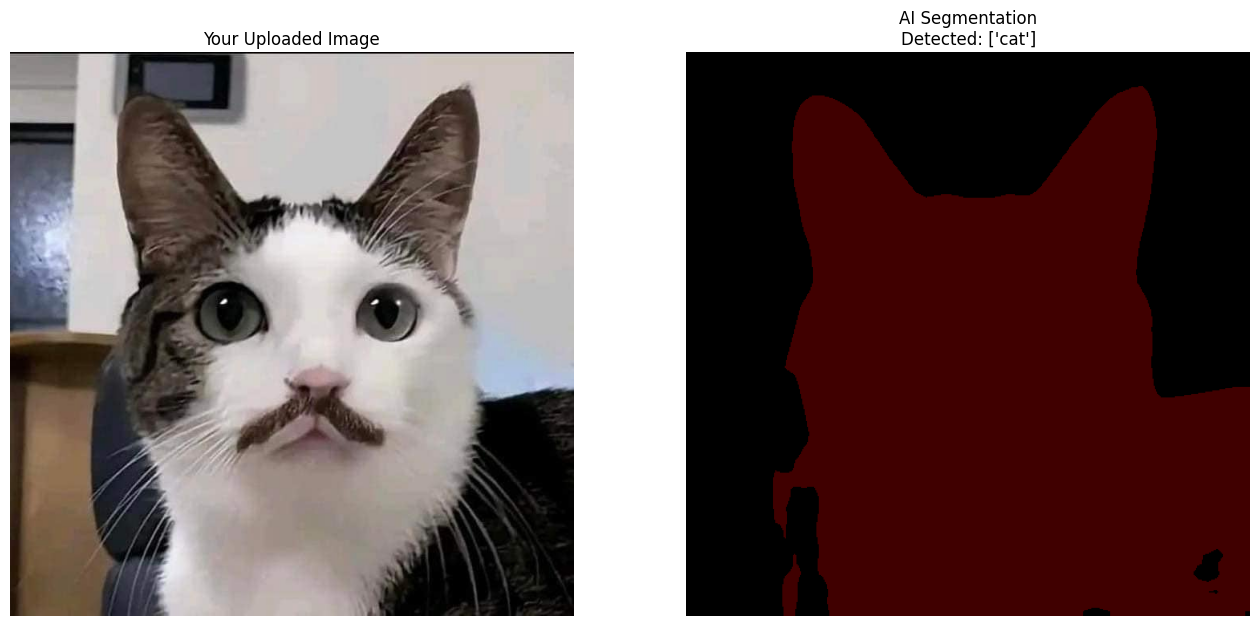

Processing Complete. Objects found: ['cat']


In [ ]:
import torch
import torchvision
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# --- 1. SETUP: Define Classes & Colors (PASCAL VOC Dataset) ---
# This is the "dictionary" the model uses to understand the world.
VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

# Distinct colors for each class (R, G, B)
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128],
    [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0], [64, 128, 0],
    [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
    [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]

# --- 2. LOAD THE MODEL (Run this once) ---
print("Initializing Model... (Downloading weights, please wait...)")
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()

# Move to GPU if available for speed
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
print(f"Model loaded on {device}!")

# --- 3. HELPER FUNCTIONS ---

def decode_segmap(image, nc=21):
    """Converts the model's number output into a colored image."""
    label_colors = np.array(VOC_COLORMAP)
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

def process_image_path(image_path):
    """Reads an image path, runs the model, and shows result."""

    # 1. Load and Preprocess
    try:
        input_image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error opening image: {e}")
        return

    preprocess = T.Compose([
        T.Resize(480), # Resize to reasonable size
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0).to(device)

    # 2. Inference (The AI Thinking)
    with torch.no_grad():
        output = model(input_batch)['out'][0]

    output_predictions = output.argmax(0).byte().cpu().numpy()

    # 3. Colorize
    rgb_prediction = decode_segmap(output_predictions)

    # 4. Visualize
    detected_ids = np.unique(output_predictions)
    detected_names = [VOC_CLASSES[i] for i in detected_ids if i < len(VOC_CLASSES) and VOC_CLASSES[i] != 'background']

    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.title("Your Uploaded Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(rgb_prediction)
    plt.title(f"AI Segmentation\nDetected: {detected_names}")
    plt.axis('off')

    plt.show()
    print(f"Processing Complete. Objects found: {detected_names}")

# --- 4. THE INTERACTIVE FUNCTION ---

def segment_new_image():
    """
    Call this function to trigger an upload button.
    """
    try:
        from google.colab import files
        print("\n--- UPLOAD A NEW IMAGE TO TEST ---")
        uploaded = files.upload()

        for filename in uploaded.keys():
            print(f"Processing {filename}...")
            process_image_path(filename)

    except ImportError:
        # Fallback for local Python (Jupyter/VSCode)
        import tkinter as tk
        from tkinter import filedialog
        root = tk.Tk()
        root.withdraw()
        print("Select an image file from the dialog window...")
        filename = filedialog.askopenfilename()
        if filename:
            process_image_path(filename)
        else:
            print("No file selected.")

# --- 5. RUN IT! ---
# You can run this line as many times as you want to try different photos.
segment_new_image()

--- INITIALIZING: Downloading Sample Images ---
Found sudoku.jpg
Found coins.jpg
Found street.jpg
Assets ready.

--- RUNNING PROCEDURE 1: THRESHOLDING ---


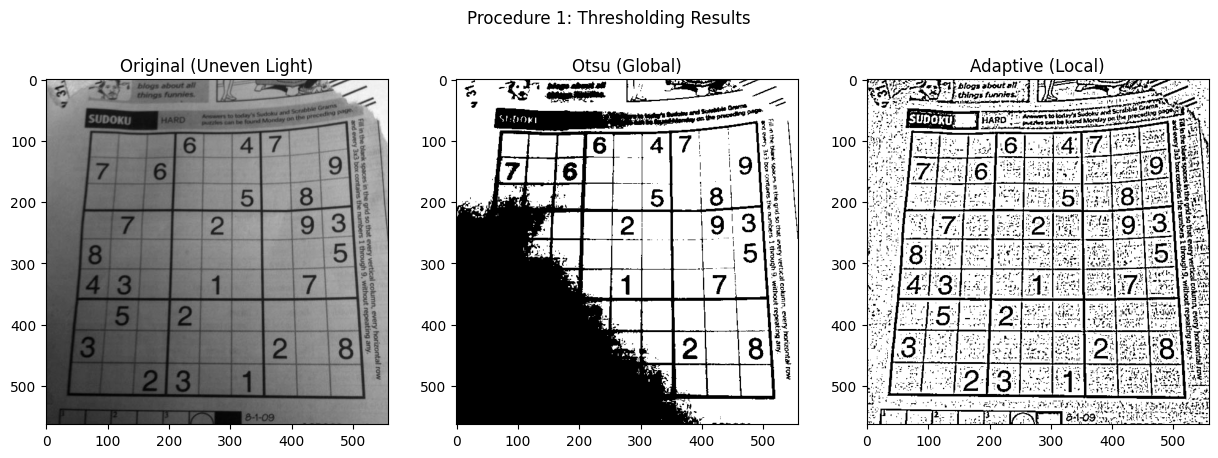

--- RUNNING PROCEDURE 2: WATERSHED SEGMENTATION ---


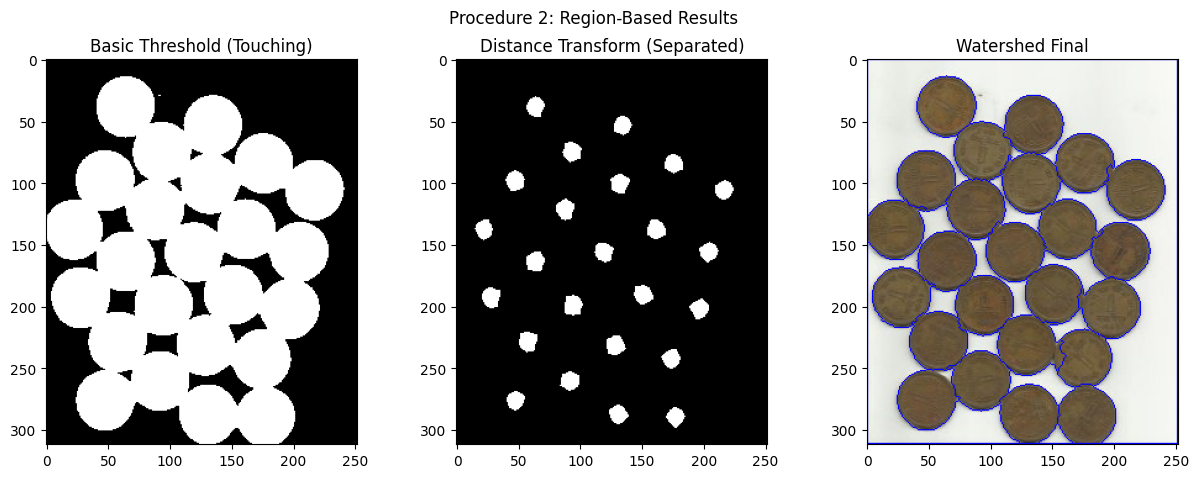

--- RUNNING PROCEDURE 3: EDGE DETECTION ---


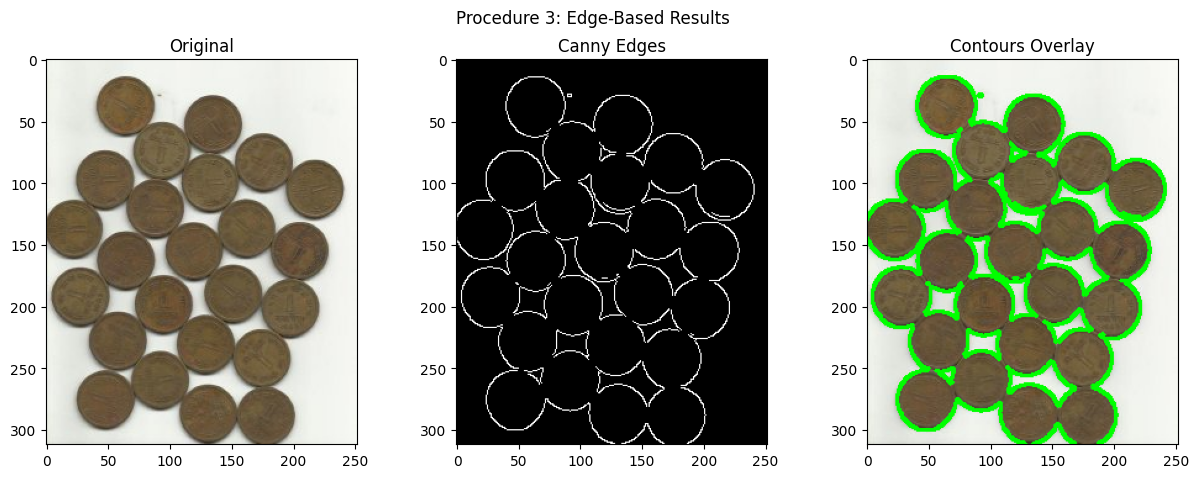

--- RUNNING PROCEDURE 4: SEMANTIC SEGMENTATION (DeepLabV3) ---
Loading model... (This may take a minute)...
Using CPU for inference.


KeyboardInterrupt: 

In [ ]:
# =============================================================================
# LABORATORY ACTIVITY 6: SEGMENTATION TECHNIQUES (COMPLETE CODE)
# =============================================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms as T
from PIL import Image
import urllib.request
import os

# --- SECTION 0: SETUP & ASSET DOWNLOAD ---
# We download standard test images so you don't have to upload anything manually.

def download_assets():
    print("--- INITIALIZING: Downloading Sample Images ---")
    assets = {
        "sudoku.jpg": "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/sudoku.png",
        "coins.jpg": "https://docs.opencv.org/4.x/water_coins.jpg",
        "street.jpg": "https://raw.githubusercontent.com/pytorch/hub/master/images/deeplab1.png"
    }

    for filename, url in assets.items():
        if not os.path.exists(filename):
            print(f"Downloading {filename}...")
            try:
                urllib.request.urlretrieve(url, filename)
            except Exception as e:
                print(f"Error downloading {filename}: {e}")
        else:
            print(f"Found {filename}")
    print("Assets ready.\n")

download_assets()

# =============================================================================
# PROCEDURE 1: THRESHOLDING SEGMENTATION
# Objective: Compare Global vs Adaptive Thresholding
# =============================================================================
print("--- RUNNING PROCEDURE 1: THRESHOLDING ---")

# Load image in Grayscale (0 flag)
img1 = cv2.imread('sudoku.jpg', 0)

# 1. Global Thresholding (Otsu's Method)
# This calculates one single threshold value for the whole image.
# It often fails if there are shadows (like in the sudoku image).
ret, otsu = cv2.threshold(img1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 2. Adaptive Thresholding
# This calculates a threshold for every small region (11x11 pixels here).
# It handles shadows perfectly.
adaptive = cv2.adaptiveThreshold(img1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)

# Visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1), plt.imshow(img1, cmap='gray'), plt.title('Original (Uneven Light)')
plt.subplot(1, 3, 2), plt.imshow(otsu, cmap='gray'), plt.title('Otsu (Global)')
plt.subplot(1, 3, 3), plt.imshow(adaptive, cmap='gray'), plt.title('Adaptive (Local)')
plt.suptitle("Procedure 1: Thresholding Results")
plt.show()


# =============================================================================
# PROCEDURE 2: REGION-BASED SEGMENTATION (WATERSHED)
# Objective: Separate touching objects
# =============================================================================
print("--- RUNNING PROCEDURE 2: WATERSHED SEGMENTATION ---")

img2 = cv2.imread('coins.jpg')
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# 1. Binarize
ret, thresh = cv2.threshold(gray2, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 2. Noise Removal (Morphological Opening)
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# 3. Find Sure Background (Dilate)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# 4. Find Sure Foreground (Distance Transform)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# 5. Find Unknown Region (Border area)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# 6. Marker Labelling
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1 # Add 1 to all so background is 1, not 0
markers[unknown == 255] = 0 # Mark unknown areas as 0

# 7. Apply Watershed
markers = cv2.watershed(img2, markers)
img2_result = img2.copy()
img2_result[markers == -1] = [255, 0, 0] # Color boundaries Red

# Visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1), plt.imshow(thresh, cmap='gray'), plt.title('Basic Threshold (Touching)')
plt.subplot(1, 3, 2), plt.imshow(sure_fg, cmap='gray'), plt.title('Distance Transform (Separated)')
plt.subplot(1, 3, 3), plt.imshow(cv2.cvtColor(img2_result, cv2.COLOR_BGR2RGB)), plt.title('Watershed Final')
plt.suptitle("Procedure 2: Region-Based Results")
plt.show()


# =============================================================================
# PROCEDURE 3: EDGE-BASED SEGMENTATION
# Objective: Detect boundaries and Contours
# =============================================================================
print("--- RUNNING PROCEDURE 3: EDGE DETECTION ---")

img3 = cv2.imread('coins.jpg')
gray3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

# 1. Canny Edge Detection
# Thresholds determine how strong an edge must be to be picked up
edges = cv2.Canny(gray3, 180, 250)

# 2. Find Contours
# This converts the edge pixels into mathematical shapes
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 3. Draw Contours
contour_img = img3.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

# Visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1), plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)), plt.title('Original')
plt.subplot(1, 3, 2), plt.imshow(edges, cmap='gray'), plt.title('Canny Edges')
plt.subplot(1, 3, 3), plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB)), plt.title('Contours Overlay')
plt.suptitle("Procedure 3: Edge-Based Results")
plt.show()


# =============================================================================
# PROCEDURE 4: SEMANTIC SEGMENTATION (DEEP LEARNING)
# Objective: Pixel-level classification using Neural Networks
# =============================================================================
print("--- RUNNING PROCEDURE 4: SEMANTIC SEGMENTATION (DeepLabV3) ---")
print("Loading model... (This may take a minute)...")

# 1. Load Model (DeepLabV3 with ResNet101 Backbone)
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval() # Set to evaluation mode

# 2. Prepare Image
input_image = Image.open("street.jpg").convert("RGB")
preprocess = T.Compose([
    T.Resize(400), # Resize to speed up processing
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # Add batch dimension

# Check for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print("Using GPU for inference.")
    input_batch = input_batch.to(device)
    model.to(device)
else:
    print("Using CPU for inference.")

# 3. Inference
with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0).byte().cpu().numpy()

# Visualization
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Original Scene')
plt.axis('off')

plt.subplot(1, 2, 2)
# nipy_spectral creates high contrast colors for different classes
plt.imshow(output_predictions, cmap='nipy_spectral')
plt.title('Semantic Segmentation Map')
plt.axis('off')

plt.suptitle("Procedure 4: Deep Learning Results")
plt.show()

print("\n--- ACTIVITY COMPLETE ---")